
Movies Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  

Ratings Dataset:
<class 'pandas.core.frame.D

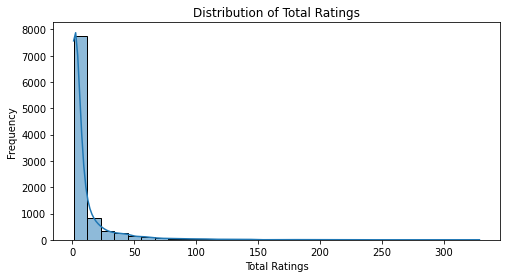


Top 10 Highly Rated Movies:
                                                    mean ratings  \
title                                                              
Scooby-Doo! and the Samurai Sword (2009)                     5.0   
Won't You Be My Neighbor? (2018)                             5.0   
Five Senses, The (1999)                                      5.0   
Wonder Woman (2009)                                          5.0   
Max Manus (2008)                                             5.0   
Martin Lawrence Live: Runteldat (2002)                       5.0   
Marriage of Maria Braun, The (Ehe der Maria Bra...           5.0   
Empties (2007)                                               5.0   
Meantime (1984)                                              5.0   
Enter the Void (2009)                                        5.0   

                                                    total ratings  
title                                                              
Scooby-Doo! and th

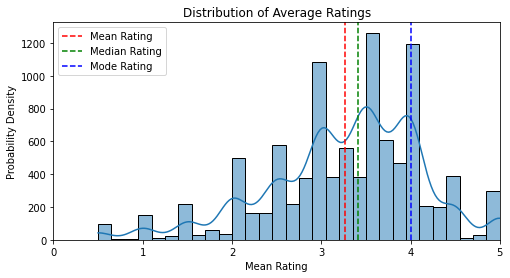


User 1 Correlation with Other Users:
userId
1      1.000000
72     0.982335
49     0.982237
189    0.982163
26     0.981986
         ...   
414    0.919988
68     0.914426
517    0.912436
599    0.899080
298    0.896667
Name: 1, Length: 610, dtype: float64

Movies Rated by User 1:
                                title  rating
0                    Toy Story (1995)     4.0
325           Grumpier Old Men (1995)     4.0
433                       Heat (1995)     4.0
2107      Seven (a.k.a. Se7en) (1995)     5.0
2379       Usual Suspects, The (1995)     5.0
...                               ...     ...
56816                    Shaft (2000)     4.0
57276                    X-Men (2000)     5.0
57457          What About Bob? (1991)     4.0
59170  Transformers: The Movie (1986)     4.0
65533    M*A*S*H (a.k.a. MASH) (1970)     5.0

[232 rows x 2 columns]

User 1 has not rated Movie ID 32.
Number of users who have rated movie 32: 9
Users who have rated movie 32: [72, 513, 521, 120, 150, 206, 56

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.cluster import KMeans
import os

# Set max CPU count for parallel processing
os.environ["LOKY_MAX_CPU_COUNT"] = "8"  

# Load datasets
movies = pd.read_csv("movies.csv", encoding='ISO-8859-1')
ratings = pd.read_csv("ratings.csv", encoding='ISO-8859-1')

# Clean column names
movies.columns = movies.columns.str.strip()
ratings.columns = ratings.columns.str.strip()

# Inspect datasets
print("\nMovies Dataset:")
movies.info()
print(movies.head())

print("\nRatings Dataset:")
ratings.info()
print(ratings.head())

# Merge datasets on 'movieId'
if 'movieId' in movies.columns and 'movieId' in ratings.columns:
    df = pd.merge(movies, ratings, on='movieId')
else:
    raise KeyError("Column 'movieId' not found in both datasets.")

# Convert timestamp to datetime (handling missing values)
if 'timestamp' in df.columns:
    df['datetime'] = pd.to_datetime(df['timestamp'], unit='s', errors='coerce')

# Inspect merged dataset
print("\nMerged Dataset Info:")
df.info()
print(df.head())

# ---- GENRE ANALYSIS ---- #
def extract_genres(df):
    """
    Extracts unique genres and counts their occurrence in the dataset.
    """
    genre_counts = {}
    for genre_list in df["genres"].dropna().str.split("|"):
        for genre in genre_list:
            genre_counts[genre] = genre_counts.get(genre, 0) + 1
    return genre_counts

# Replace '(no genres listed)' with 'Unknown'
movies["genres"] = movies["genres"].replace("(no genres listed)", "Unknown")

# Get genre distribution
genre_distribution = extract_genres(movies)
print("\nGenre Distribution (Top 10):", sorted(genre_distribution.items(), key=lambda x: x[1], reverse=True)[:10])

# ---- MOVIE RATING ANALYSIS ---- #
df_ratings_summary = df.groupby("title")["rating"].agg(["mean", "count"]).rename(columns={"mean": "mean ratings", "count": "total ratings"})

# Sort by total ratings
df_ratings_summary.sort_values(by="total ratings", ascending=False, inplace=True)

# **Top 10 Most Rated Movies**
print("\nTop 10 Most Rated Movies:")
print(df_ratings_summary.head(10))

# **Distribution of Ratings**
plt.figure(figsize=(8, 4))
sns.histplot(df_ratings_summary["total ratings"], bins=30, kde=True)
plt.xlabel("Total Ratings")
plt.ylabel("Frequency")
plt.title("Distribution of Total Ratings")
plt.show()

# ---- HIGHLY RATED MOVIES ---- #
df_ratings_summary.sort_values(by="mean ratings", ascending=False, inplace=True)

# Filter movies that have a perfect 5.0 rating
highly_rated_movies = df_ratings_summary[df_ratings_summary["mean ratings"] == 5.0]

# **Top 10 Highly Rated Movies**
print("\nTop 10 Highly Rated Movies:")
print(highly_rated_movies.head(10))

# **Number of Users Who Gave 5.0 Ratings**
total_users_5 = highly_rated_movies["total ratings"].sum()
print(f"\nTotal Users Who Rated a Movie as 5.0: {total_users_5}")

# **Number of Movies Rated 5.0 by a Single User**
single_user_rated_5 = len(highly_rated_movies[highly_rated_movies["total ratings"] == 1])
print(f"Movies Rated 5.0 by Only One User: {single_user_rated_5}")

# **Distribution of Ratings**
plt.figure(figsize=(8, 4))
sns.histplot(df_ratings_summary["mean ratings"], bins=30, kde=True)
plt.xlim(0, 5)
plt.axvline(df_ratings_summary["mean ratings"].mean(), color='red', linestyle='--', label='Mean Rating')
plt.axvline(df_ratings_summary["mean ratings"].median(), color='green', linestyle='--', label='Median Rating')
plt.axvline(df_ratings_summary["mean ratings"].mode()[0], color='blue', linestyle='--', label='Mode Rating')
plt.legend()
plt.title("Distribution of Average Ratings")
plt.xlabel("Mean Rating")
plt.ylabel("Probability Density")
plt.show()

# ---- USER-ITEM MATRIX FOR COLLABORATIVE FILTERING ---- #
# Create a pivot table (handling duplicate ratings by taking the mean)
pivot_table = df.pivot_table(index='userId', columns='title', values='rating', aggfunc='mean')

# Fill NaN values with each movie's average rating
user_util_matrix = pivot_table.apply(lambda col: col.fillna(col.mean()), axis=0)

# Compute user-user similarity matrix using Pearson correlation
user_corr_mat = user_util_matrix.T.corr()

# Choose the correlation of all users with only User 1
if 1 in user_corr_mat.index:
    corr_user_1 = user_corr_mat.loc[1].sort_values(ascending=False).dropna()
    print("\nUser 1 Correlation with Other Users:")
    print(corr_user_1)
else:
    print("\nUser 1 is not present in the dataset.")


# Choose the Top 50 users that are highly correlated with User 1 (excluding itself)
top50_corr_users = corr_user_1.iloc[1:51] if len(corr_user_1) > 1 else None

# List all the movies rated by User 1
user_1_movies = df[df['userId'] == 1][['title', 'rating']]
print("\nMovies Rated by User 1:")
print(user_1_movies)

# Predict User 1's rating for Movie ID 32
user_1_movie32 = df[(df["userId"] == 1) & (df["movieId"] == 32)]
if not user_1_movie32.empty:
    print("\nUser 1's Rating for Movie ID 32:")
    print(user_1_movie32[['title', 'rating']])
else:
    print("\nUser 1 has not rated Movie ID 32.")

top50_users = top50_corr_users.keys()
count = 0
users = list()
for user in top50_users:
    if df[ (df['userId'] == user) & (df['movieId'] == 32)]['rating'].sum():    
        count += 1
        users.append(user)
print(f"Number of users who have rated movie 32: {count}")
print(f"Users who have rated movie 32: {users}")  

# Calculate the rating user 1 would give to the movie
def predict_ratings():
    sum_similarity = 0
    weighted_ratings = 0
    for user in users:
        weighted_ratings += top50_corr_users.loc[user] * df[(df["userId"] == user) & 
        (df["movieId"] == 32)]['rating'].sum()
        sum_similarity +=top50_corr_users.loc[user]
    print(weighted_ratings/sum_similarity)

predict_ratings()

'''
        Observation - * The predited rating for Movie 32 is 4.000018023600582 which is quite good and would recomand

'''

#. Perform Item based collaborating Filtering
item_util_matrix = pivot_table.copy()
#print(item_util_matrix.head(5))
item_util_matrix = item_util_matrix.apply(lambda col : col.fillna(col.mean()), axis=0)
print(item_util_matrix.head(5))
item_util_matrix.isna().sum().sum()
item_corr_matrix = item_util_matrix.corr()

# Choose the correlation of all the movies with the movie Jurassic Park(1993) only
df_ratings_summary.loc[['Jurassic Park (1993)']]

# Sort the Jurassic Park (1993) movie correlection in Desending order
jurassic_park_corr = item_corr_matrix['Jurassic Park (1993)']
jurassic_park_corr = jurassic_park_corr.sort_values(ascending=False)
jurassic_park_corr.dropna(inplace=True)

# find the most 10 movies similar to the movie Jurassic Park (1993)
movies_similar_to_jurassic_park = pd.DataFrame(data=jurassic_park_corr.values, columns=['Correlation'],
                                               index= jurassic_park_corr.index)
movies_similar_to_jurassic_park = movies_similar_to_jurassic_park.join(df_ratings_summary['total ratings'])
print(movies_similar_to_jurassic_park.head(10))



In [3]:
# Model Based Collaborative Filtering
# Perform KNNBasic, SVD, NMF Model-Based collaborative Filtering


from surprise import Dataset, Reader
from surprise import KNNBasic, SVD, NMF
from surprise.model_selection import cross_validate

# Load dataset into Surprise format
reader = Reader(rating_scale=(0.5, 5.0))  # Ratings range from 0.5 to 5.0
data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)

# ---- MODEL 1: KNNBasic ---- #
knn_algo = KNNBasic(sim_options={'name': 'msd', 'user_based': True}, k=20)
knn_cv_results = cross_validate(knn_algo, data, measures=['RMSE'], cv=5, verbose=True)

# ---- MODEL 2: Singular Value Decomposition (SVD) ---- #
svd_algo = SVD()
svd_cv_results = cross_validate(svd_algo, data, measures=['RMSE'], cv=5, verbose=True)

# ---- MODEL 3: Non-Negative Matrix Factorization (NMF) ---- #
nmf_algo = NMF()
nmf_cv_results = cross_validate(nmf_algo, data, measures=['RMSE'], cv=5, verbose=True)

# ---- Compare Performance ---- #
print("\nModel Performance (RMSE - Lower is better):")
print(f"KNNBasic RMSE: {np.mean(knn_cv_results['test_rmse'])}")
print(f"SVD RMSE: {np.mean(svd_cv_results['test_rmse'])}")
print(f"NMF RMSE: {np.mean(nmf_cv_results['test_rmse'])}")

# ---- Find the Best Model ---- #
best_model = min(
    [("KNNBasic", np.mean(knn_cv_results['test_rmse'])),
     ("SVD", np.mean(svd_cv_results['test_rmse'])),
     ("NMF", np.mean(nmf_cv_results['test_rmse']))],
    key=lambda x: x[1]
)

print(f"\n🏆 Best Model: {best_model[0]} with RMSE = {best_model[1]}")

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9434  0.9297  0.9460  0.9404  0.9490  0.9417  0.0066  
Fit time          0.05    0.08    0.07    0.07    0.07    0.07    0.01    
Test time         0.80    0.73    0.81    0.73    0.85    0.78    0.05    
Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8745  0.8737  0.8770  0.8732  0.8727  0.8742  0.0015  
Fit time          4.27    4.22    4.23    4.28    4.24    4.25    0.02    
Test ti